In [1]:
# Get rid of annoying tf warning
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import pickle
import numpy as np
np.set_printoptions(suppress=True)

import bayesflow as beef
import tensorflow as tf

import sys
sys.path.append("../")
from experiment import ModelComparisonExperiment

/home/divergence/anaconda3/envs/bfPower/lib/python3.10/site-packages/bayesflow/trainers.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# gpu setting and checking
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
experiment = ModelComparisonExperiment()

INFO:root:Trainer initialization: No generative model provided. Only offline learning mode is available!
INFO:root:Loaded loss history from ../checkpoints/model_comparison/history_50.pkl.
INFO:root:Networks loaded from ../checkpoints/model_comparison/ckpt-50


In [4]:
TRAIN_NETWORK = False

# Training

In [5]:
if TRAIN_NETWORK:
    with open('../data/training_data.pkl', 'rb') as f:
        training_data = pickle.load(f)
    with open('../data/validation_data.pkl', 'rb') as f:
        training_validation_data = pickle.load(f)
        
    history = experiment.run(
        training_data=training_data,
        validation_data=None
    )

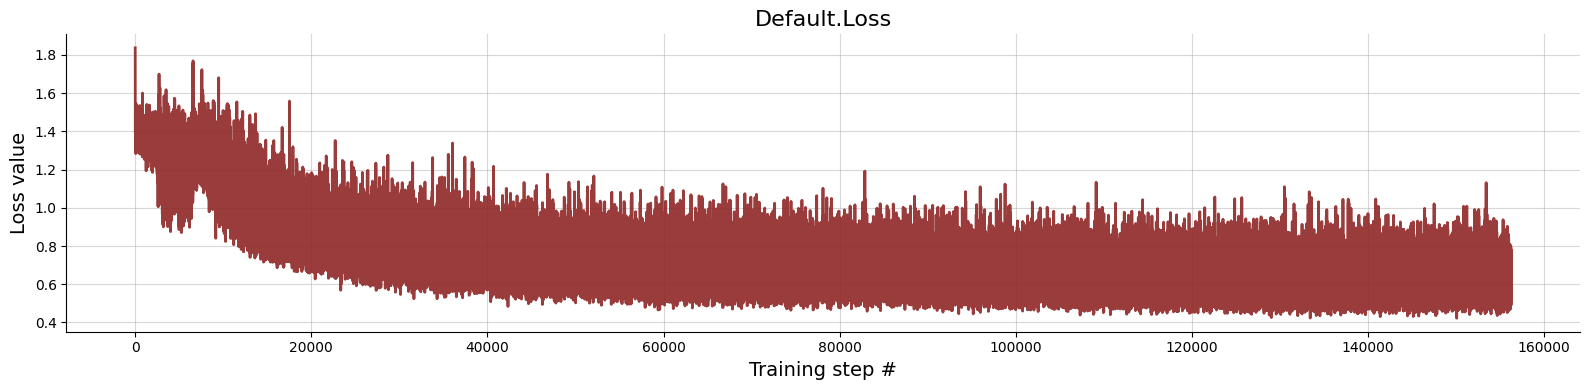

In [6]:
f = beef.diagnostics.plot_losses(experiment.trainer.loss_history.get_plottable())

# Validation

In [17]:
with open('../data/validation_data.pkl', 'rb') as f:
    validation_data = pickle.load(f)

In [18]:
configurator = beef.configuration.DefaultModelComparisonConfigurator(4)

In [ ]:
model_probs = np.zeros((40000, 4))
chunks = np.arange(0, 10001, 200)
for i in range(len(chunks)-1):
    sim_1 = {'sim_data': validation_data['model_outputs'][0]['sim_data'][chunks[i]:chunks[i+1]]}
    sim_2 = {'sim_data': validation_data['model_outputs'][1]['sim_data'][chunks[i]:chunks[i+1]]}
    sim_3 = {'sim_data': validation_data['model_outputs'][2]['sim_data'][chunks[i]:chunks[i+1]]}
    sim_4 = {'sim_data': validation_data['model_outputs'][3]['sim_data'][chunks[i]:chunks[i+1]]}
    
    tmp_validation_data = {
        'model_outputs': [sim_1, sim_2, sim_3, sim_4],
        'model_indices': validation_data['model_indices']
    }
    
    tmp_validation_data_configured = configurator(tmp_validation_data)
    with tf.device('/cpu:0'):
        model_probs[(chunks[i]*4):(chunks[i+1]*4)] = experiment.amortizer.posterior_probs(
            tmp_validation_data_configured
        )
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [ ]:
validation_data_configured = configurator(validation_data)

In [ ]:
cal_curves = beef.diagnostics.plot_calibration_curves(
    true_models=validation_data_configured['model_indices'],
    pred_models=model_probs,
    model_names=['Random walk',
                 'Mixture random walk',
                 'Levy flight',
                 'Regime switching'],
    fig_size=(14, 3)
)

In [ ]:
confusion_matrix = beef.diagnostics.plot_confusion_matrix(
    validation_data_configured['model_indices'],
    model_probs,
    model_names=['RW', 'MRW', 'LF', 'RS']
)